## Setup

In [1]:
# Necessary imports

from datetime import datetime, timedelta
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.stats import iqr
import shutil
import zipfile
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from pathlib import Path

%matplotlib inline

In [2]:
start_time = datetime.now()

In [3]:
# Download data from OpenNeuro ⏳

!openneuro-py download --dataset ds005025 --target-dir data-human/


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds005025 …
GraphQL query failed with 1 errors
╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/openneu │
│ ro/_download.py:217 in _get_download_metadata                                │
│                                                                              │
│   214 │   │   │   if msg == "You do not have access to read this dataset.":  │
│   215 │   │   │   │   try:                                                   │
│   216 │   │   │   │   │   # Do we have an API token?                         │
│ ❱ 217 │   │   │   │   │   get_token()                                        │
│   218 │   │   │   │   │   raise RuntimeError(                                │
│   219 │   │   │   │   │   │   "We

In [4]:
# Define useful variables
path_data = os.path.join(os.getcwd(), "data-human/")
print(f"path_data: {path_data}")
path_labels = os.path.join(path_data, "derivatives", "labels")
path_qc = os.path.join(path_data, "qc")
subjects = [os.path.basename(subject_path) for subject_path in sorted(glob.glob(os.path.join(path_data, "sub-*")))]
print(f"subjects: {subjects}")

# Create output folder
path_results = os.path.join(path_data, "derivatives", "results")
os.makedirs(path_results, exist_ok=True)

path_data: /home/runner/work/coil-qc-code/coil-qc-code/data-human/
subjects: []


## MP2RAGE segmentation and vertebral labeling 

In [5]:
# Run segmentation on MP2RAGE scan ⏳

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "anat"))
    fname_manual_seg = os.path.join(path_labels, subject, "anat", f"{subject}_UNIT1_label-SC_seg.nii.gz")
    if os.path.exists(fname_manual_seg):
        # Manual segmentation already exists. Copy it to local folder
        print(f"{subject}: Manual segmentation found\n")
        shutil.copyfile(fname_manual_seg, f"{subject}_UNIT1_seg.nii.gz")
        # Generate QC report to make sure the manual segmentation is correct
        !sct_qc -i {subject}_UNIT1.nii.gz -s {subject}_UNIT1_seg.nii.gz -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
    else:
        # Manual segmentation does not exist. Run automatic segmentation.
        print(f"{subject}: Manual segmentation not found")
        #EAO: remove -qc {path_qc} because its giving me an error
        !sct_deepseg -i "{subject}_UNIT1.nii.gz" -task seg_sc_contrast_agnostic 

In [6]:
# Label vertebrae

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "anat"))
    fname_manual_labels = os.path.join(path_labels, subject, "anat", f"{subject}_UNIT1_label-disc.nii.gz")
    if os.path.exists(fname_manual_labels):
        # Use manual disc labels to generate labeled segmentation.
        print(f"{subject}: Manual labels found\n")
        !sct_label_utils -i {subject}_UNIT1_seg.nii.gz -disc {fname_manual_labels} -o {subject}_UNIT1_seg_labeled.nii.gz
        # Generate QC report to assess labeled segmentation
        !sct_qc -i {subject}_UNIT1.nii.gz -s {subject}_UNIT1_seg_labeled.nii.gz -p sct_label_vertebrae -qc {path_qc} -qc-subject {subject}
    else:
        # Manual labels do not exist. Run vertebrae labeling.
        print(f"{subject}: Manual labels not found.")

In [7]:
# Crop MP2RAGE for faster processing and better registration results
dilation_kernel="20x20x0"

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "anat"))
    !sct_crop_image -i {subject}_inv-1_part-mag_MP2RAGE.nii.gz -m {subject}_UNIT1_seg.nii.gz -dilate {dilation_kernel} -o {subject}_inv-1_part-mag_MP2RAGE_crop.nii.gz 
    !sct_crop_image -i {subject}_UNIT1.nii.gz -m {subject}_UNIT1_seg.nii.gz -dilate {dilation_kernel} -o {subject}_UNIT1_crop.nii.gz
    !sct_crop_image -i {subject}_UNIT1_seg.nii.gz -m {subject}_UNIT1_seg.nii.gz -dilate {dilation_kernel} -o {subject}_UNIT1_seg_crop.nii.gz
    !sct_crop_image -i {subject}_UNIT1_seg_labeled.nii.gz -m {subject}_UNIT1_seg.nii.gz -dilate {dilation_kernel} -o {subject}_UNIT1_seg_labeled_crop.nii.gz

## Register spinal cord segmentation and labels to TFL and DREAM flip angle maps and SNR maps

In [8]:
# Segment spinal cord on TFL data (B1+ mapping) ⏳

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    fname_manual_seg = os.path.join(path_labels, subject, "fmap", f"{subject}_acq-anat_TB1TFL_label-SC_seg.nii.gz")
    if os.path.exists(fname_manual_seg):
        # Manual segmentation already exists. Copy it to local folder
        print(f"{subject}: Manual segmentation found\n")
        shutil.copyfile(fname_manual_seg, f"{subject}_acq-anat_TB1TFL_seg.nii.gz")
        # Generate QC report to make sure the manual segmentation is correct
        !sct_qc -i "{subject}_acq-anat_TB1TFL.nii.gz" -s "{subject}_acq-anat_TB1TFL_seg.nii.gz" -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
    else:
        # Manual segmentation does not exist. Run automatic segmentation.
        print(f"{subject}: Manual segmentation not found")
        #EAO: remove -qc {path_qc} because its giving me an error
        !sct_deepseg -i "{subject}_acq-anat_TB1TFL.nii.gz" -task seg_sc_contrast_agnostic 

In [9]:
# Register TFL data (B1+ mapping) to the MP2RAGE scan ⏳

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    if subject=="sub-CRMBM2" or subject=="sub-MPI2":
        #https://github.com/spinal-cord-7t/coil-qc-code/issues/48
        !sct_register_multimodal -i {subject}_acq-anat_TB1TFL.nii.gz -iseg {subject}_acq-anat_TB1TFL_seg.nii.gz -d ../anat/{subject}_UNIT1_crop.nii.gz -dseg ../anat/{subject}_UNIT1_seg_crop.nii.gz -param step=1,type=seg,algo=centermass -qc "{path_qc}"
    else:
        if subject=='sub-MSSM1' or subject=='sub-MSSM2' or subject=='sub-MSSM3':
            #https://github.com/spinal-cord-7t/coil-qc-code/issues/43
            !sct_register_multimodal -i {subject}_acq-famp_TB1TFL.nii.gz -iseg {subject}_acq-anat_TB1TFL_seg.nii.gz -d ../anat/{subject}_inv-1_part-mag_MP2RAGE_crop.nii.gz -dseg ../anat/{subject}_UNIT1_seg_crop.nii.gz -param step=1,type=seg,algo=centermass -qc "{path_qc}"
        else:
            !sct_register_multimodal -i {subject}_acq-anat_TB1TFL.nii.gz -iseg {subject}_acq-anat_TB1TFL_seg.nii.gz -d ../anat/{subject}_inv-1_part-mag_MP2RAGE_crop.nii.gz -dseg ../anat/{subject}_UNIT1_seg_crop.nii.gz -param step=1,type=seg,algo=centermass -qc "{path_qc}"

In [10]:
# Register DREAM data (B1+ mapping) to the MP2RAGE scan ⏳

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    !sct_register_multimodal -i {subject}_acq-famp_TB1DREAM.nii.gz -d ../anat/{subject}_UNIT1_crop.nii.gz -dseg ../anat/{subject}_UNIT1_seg_crop.nii.gz -param step=1,type=im,algo=slicereg,metric=CC,smooth=1 -qc "{path_qc}"

In [11]:
# Register Rx coilQA data (SNR, g-factor) to the MP2RAGE scan ⏳

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    # Split SNR data into sub-volumes (https://github.com/spinal-cord-7t/coil-qc-code/issues/34)
    !sct_image -i {subject}_acq-coilQaSagLarge_SNR.nii.gz -split t -o {subject}_acq-coilQaSagLarge_SNR.nii.gz
    # Segment spinal cord on SNR map
    #EAO: remove -qc {path_qc} because its giving me an error
    !sct_deepseg -i {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -task seg_sc_contrast_agnostic 
    # Use the 1st volume of the SNR data, which corresponds to the sum-of-square SNR reconstruction
    !sct_register_multimodal -i {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -d ../anat/{subject}_UNIT1_crop.nii.gz -iseg {subject}_acq-coilQaSagLarge_SNR_T0000_seg.nii.gz -dseg ../anat/{subject}_UNIT1_seg_crop.nii.gz -param step=1,type=seg,algo=centermass -qc "{path_qc}"

In [12]:
# Warping spinal cord segmentation and vertebral level to each flip angle and SNR map

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    
    # Warping SC segmentation and vertebral levels to TFL fmaps 
    if subject=="sub-CRMBM2" or subject=="sub-MPI2":
        #https://github.com/spinal-cord-7t/coil-qc-code/issues/48
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_crop.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_UNIT1_crop2{subject}_acq-anat_TB1TFL.nii.gz -x linear -o {subject}_acq-famp_TB1TFL_seg.nii.gz
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled_crop.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_UNIT1_crop2{subject}_acq-anat_TB1TFL.nii.gz -x nn -o {subject}_acq-famp_TB1TFL_seg_labeled.nii.gz
        
    elif subject=='sub-MSSM1' or subject=='sub-MSSM2' or subject=='sub-MSSM3':   
        #https://github.com/spinal-cord-7t/coil-qc-code/issues/43
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_crop.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_inv-1_part-mag_MP2RAGE_crop2{subject}_acq-famp_TB1TFL.nii.gz -x linear -o {subject}_acq-famp_TB1TFL_seg.nii.gz
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled_crop.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_inv-1_part-mag_MP2RAGE_crop2{subject}_acq-famp_TB1TFL.nii.gz -x nn -o {subject}_acq-famp_TB1TFL_seg_labeled.nii.gz
        
    else:
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_crop.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_inv-1_part-mag_MP2RAGE_crop2{subject}_acq-anat_TB1TFL.nii.gz -x linear -o {subject}_acq-famp_TB1TFL_seg.nii.gz
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled_crop.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_inv-1_part-mag_MP2RAGE_crop2{subject}_acq-anat_TB1TFL.nii.gz -x nn -o {subject}_acq-famp_TB1TFL_seg_labeled.nii.gz
        
    !sct_qc -i {subject}_acq-famp_TB1TFL.nii.gz -s {subject}_acq-famp_TB1TFL_seg.nii.gz -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
    !sct_qc -i {subject}_acq-famp_TB1TFL.nii.gz -s {subject}_acq-famp_TB1TFL_seg_labeled.nii.gz -p sct_label_vertebrae -qc {path_qc} -qc-subject {subject}
    
    # Warping SC segmentation and vertebral levels to DREAM fmaps 
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_crop.nii.gz -d {subject}_acq-famp_TB1DREAM.nii.gz -w warp_{subject}_UNIT1_crop2{subject}_acq-famp_TB1DREAM.nii.gz -x linear -o {subject}_acq-famp_TB1DREAM_seg.nii.gz
    !sct_qc -i {subject}_acq-famp_TB1DREAM.nii.gz -s {subject}_acq-famp_TB1DREAM_seg.nii.gz -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
    
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled_crop.nii.gz -d {subject}_acq-famp_TB1DREAM.nii.gz -w warp_{subject}_UNIT1_crop2{subject}_acq-famp_TB1DREAM.nii.gz -x nn -o {subject}_acq-famp_TB1DREAM_seg_labeled.nii.gz
    !sct_qc -i {subject}_acq-famp_TB1DREAM.nii.gz -s {subject}_acq-famp_TB1DREAM_seg_labeled.nii.gz -p sct_label_vertebrae -qc {path_qc} -qc-subject {subject}
    
    # Warping SC segmentation and vertebral level to SNR maps
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_crop.nii.gz -d {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -w warp_{subject}_UNIT1_crop2{subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -x linear -o {subject}_acq-coilQaSagLarge_SNR_T0000_seg.nii.gz
    !sct_qc -i {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -s {subject}_acq-coilQaSagLarge_SNR_T0000_seg.nii.gz -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
    
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled_crop.nii.gz -d {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -w warp_{subject}_UNIT1_crop2{subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -x nn -o {subject}_acq-coilQaSagLarge_SNR_T0000_seg_labeled.nii.gz
    !sct_qc -i {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -s {subject}_acq-coilQaSagLarge_SNR_T0000_seg_labeled.nii.gz -p sct_label_vertebrae -qc {path_qc} -qc-subject {subject}

## Convert TFL and DREAM flip angle maps to B1+ in units of nT/V 

In [13]:
# load DREAM FA maps acquired with different reference voltages
# threshold FA maps to 20deg < FA < 50deg
# combine FA maps by averaging non-zero estimates of FA in each pixel

GAMMA = 2.675e8;  # [rad / (s T)]
voltages = ["1.5", "0.66"]

for subject in subjects:
    
    b1_maps = []
    os.chdir(os.path.join(path_data, subject, "fmap"))

    if subject=='sub-MSSM1':
        ref_voltage=450
    elif subject=='sub-MSSM2':
        ref_voltage=350
    elif subject=='sub-MSSM3':
        ref_voltage=450
    else:     
        # Fetch the reference voltage from the JSON sidecar 
        with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
            metadata = json.load(f)
            ref_voltage = metadata.get("TxRefAmp", "N/A")
            if (ref_voltage == "N/A"):
                ref_token = "N/A"
                for token in metadata.get("SeriesDescription", "N/A").split("_"):
                    if token.startswith("RefV"): ref_token = token
                ref_voltage = float(ref_token[4:-1])
    
    # Open refV flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1DREAM.nii.gz")
    meas_fa = nii.get_fdata()
    #thresholding
    meas_fa[meas_fa < 200] = np.nan
    meas_fa[meas_fa > 500] = np.nan

    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
        meas_fa = (meas_fa/10) / requested_fa

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095
    # Compute B1 map in [T/V]
    b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
    # Convert to [nT/V]
    b1_map = b1_map * 1e9
    
    b1_maps.append(b1_map)

    for voltage in voltages:
        
        #check if map exists
        my_file = Path(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
        
        if my_file.is_file():
            
            if subject=='sub-MSSM2' and voltage=="1.5":
                ref_voltage=450
            elif subject=='sub-MSSM2' and voltage=="0.66":
                ref_voltage=234
            elif subject=='sub-MSSM3' and voltage=="0.66":
                ref_voltage=328
            else:            
                # Fetch the reference voltage from the JSON sidecar 
                with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                    metadata = json.load(f)
                    ref_voltage = metadata.get("TxRefAmp", "N/A")
                    if (ref_voltage == "N/A"):
                        ref_token = "N/A"
                        for token in metadata.get("SeriesDescription", "N/A").split("_"):
                            if token.startswith("RefV"): ref_token = token
                        ref_voltage = float(ref_token[4:-1])
                
            # Open flip angle map with nibabel
            nii = nib.load(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
            meas_fa = nii.get_fdata()
            #thresholding
            meas_fa[meas_fa < 200] = np.nan
            meas_fa[meas_fa > 500] = np.nan
        
            # Fetch the flip angle from the JSON sidecar 
            with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                metadata = json.load(f)
                requested_fa = metadata.get("FlipAngle", "N/A")
                #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
                meas_fa = (meas_fa/10) / requested_fa
        else:
            meas_fa = np.full((nii.header).get_data_shape(),np.nan)

        # Account for the power loss between the coil and the socket. That number was given by Siemens.
        voltage_at_socket = ref_voltage * 10 ** -0.095
        # Compute B1 map in [T/V]
        # Siemens maps are in units of flip angle * 10 (in degrees)
        b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
        # Convert to [nT/V]
        b1_map = b1_map * 1e9
        
        b1_maps.append(b1_map)
 
    # compute mean of non-zero values
    avgB1=np.nanmean(b1_maps,axis=0)
    
    # Save as NIfTI file
    nii_avgB1 = nib.Nifti1Image(avgB1, nii.affine, nii.header)
    nib.save(nii_avgB1, f"{subject}_DREAMTB1avgB1map.nii.gz")
    

In [14]:
# Convert the TFL flip angle maps to B1+ efficiency maps [nT/V] (inspired by code from Kyle Gilbert)
# The approach consists in calculating the B1+ efficiency using a 1ms, pi-pulse at the acquisition voltage,
# then scale the efficiency by the ratio of the measured flip angle to the requested flip angle in the pulse sequence.

GAMMA = 2.675e8;  # [rad / (s T)]

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))

    if subject=='sub-MSSM1':
        ref_voltage=450
    elif subject=='sub-MSSM2':
        ref_voltage=350
    elif subject=='sub-MSSM3':
        ref_voltage=450
    else:     
        # Fetch the reference voltage from the JSON sidecar 
        with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
            metadata = json.load(f)
            ref_voltage = metadata.get("TxRefAmp", "N/A")
            if (ref_voltage == "N/A"):
                ref_token = "N/A"
                for token in metadata.get("SeriesDescription", "N/A").split("_"):
                    if token.startswith("RefV"): ref_token = token
                ref_voltage = float(ref_token[4:-1])
        
    print(f"ref_voltage [V]: {ref_voltage} ({subject}_acq-famp_TB1TFL)")
                
    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        print(f"flip angle [degrees]: {requested_fa} ({subject}_acq-famp_TB1TFL)")

    # Open flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1TFL.nii.gz")
    meas_fa = nii.get_fdata()

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095

    # Compute B1 map in [T/V]
    # Siemens maps are in units of flip angle * 10 (in degrees)
    b1_map = ((meas_fa / 10) / requested_fa) * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))

    # Convert to [nT/V]
    b1_map = b1_map * 1e9

    # Save B1 map in [T/V] as NIfTI file
    nii_b1 = nib.Nifti1Image(b1_map, nii.affine, nii.header)
    nib.save(nii_b1, f"{subject}_TFLTB1map.nii.gz")


## Extract B1+ and SNR along the spinal cord 

In [15]:
# Extract B1+ and SNR along the spinal cord between levels C3 and T2 (included) and save data to CSV files

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    
    fname_result_b1plus = os.path.join(path_results, f"{subject}_TFLTB1map.csv")
    # Dilate TFL-registered SC segmentation 
    if subject=='sub-MSSM1' or subject=='sub-MSSM2' or subject=='sub-MSSM3':
        #https://github.com/spinal-cord-7t/coil-qc-code/issues/43
        !sct_maths -i {subject}_acq-famp_TB1TFL_seg.nii.gz -o {subject}_acq-famp_TB1TFL_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
    else:   
        !sct_maths -i {subject}_acq-anat_TB1TFL_seg.nii.gz -o {subject}_acq-famp_TB1TFL_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
    !sct_extract_metric -i {subject}_TFLTB1map.nii.gz -f {subject}_acq-famp_TB1TFL_seg_dilated.nii.gz -method wa -vert 1:9 -vertfile {subject}_acq-famp_TB1TFL_seg_labeled.nii.gz -perlevel 1 -o "{fname_result_b1plus}"     
            
    fname_result_b1plus = os.path.join(path_results, f"{subject}_DREAMTB1avgB1map.csv")
    # Dilate DREAM-registered SC segmentation 
    !sct_maths -i {subject}_acq-famp_TB1DREAM_seg.nii.gz -o {subject}_acq-famp_TB1DREAM_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
    !sct_extract_metric -i {subject}_DREAMTB1avgB1map.nii.gz -f {subject}_acq-famp_TB1DREAM_seg_dilated.nii.gz -method wa -vert 1:9 -vertfile {subject}_acq-famp_TB1DREAM_seg_labeled.nii.gz -perlevel 1 -o "{fname_result_b1plus}"
    
    fname_result_SNR = os.path.join(path_results, f"{subject}_SNRmap.csv")
    # Dilate SNR-registered SC segmentation 
    !sct_maths -i {subject}_acq-coilQaSagLarge_SNR_T0000_seg.nii.gz -o {subject}_acq-coilQaSagLarge_SNR_T0000_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
    !sct_extract_metric -i {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -f {subject}_acq-coilQaSagLarge_SNR_T0000_seg_dilated.nii.gz -method wa -vert 1:9 -vertfile {subject}_acq-coilQaSagLarge_SNR_T0000_seg_labeled.nii.gz -perlevel 1 -o "{fname_result_SNR}"

## Load data and generate figures

In [16]:
##################################################################################
# load data, interpolate to vertebral levels, and save to data structures
##################################################################################

In [17]:
# reorder subjects so that identical coils are displayed side-by-side
subjects = ['sub-CRMBM1', 'sub-CRMBM2', 'sub-CRMBM3', 'sub-UCL1', 'sub-UCL2', 'sub-UCL3', 'sub-MNI1', 'sub-MNI2', 'sub-MNI3', 'sub-MGH1', 'sub-MGH2', 'sub-MGH3', 'sub-MPI1', 'sub-MPI2', 'sub-MPI3', 'sub-NTNU1', 'sub-NTNU2', 'sub-NTNU3', 'sub-MSSM1', 'sub-MSSM2', 'sub-MSSM3']

In [18]:
# Go back to root data folder
os.chdir(os.path.join(path_data))

def smooth_data(data, window_size=20):
    """ Apply a simple moving average to smooth the data. """
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Fixed grid for x-axis
x_grid = np.linspace(0, 1, 100)

# z-slices corresponding to levels C3 to T2 on the PAM50 template. These will be used to scale the x-label of each subject.
original_vector = np.array([985, 939, 907, 870, 833, 800, 769, 735, 692, 646])

# Normalize the PAM50 z-slice numbers to the 1-0 range (to show inferior-superior instead of superior-inferior)
min_val = original_vector.min()
max_val = original_vector.max()
normalized_vector = 1 - ((original_vector - min_val) / (max_val - min_val))

# Use this normalized vector as x-ticks
custom_xticks = normalized_vector

# Vertebral level labels
vertebral_levels = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "T1", "T2"]
# Calculate midpoints for label positions
label_positions = normalized_vector[:-1] + np.diff(normalized_vector) / 2

sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]

# map types
map_types = ["TFLTB1", "DREAMTB1avgB1", "SNR"]

# Data storage for statistics
TFLTB1_data_stats = []
DREAMTB1avgB1_data_stats = []
SNR_TB1_data_stats = []

data_stats = [TFLTB1_data_stats, DREAMTB1avgB1_data_stats, SNR_TB1_data_stats]

# Data storage 
TFLTB1_data = {}
DREAMTB1avgB1_data = {}
SNR_data = {}
data = [TFLTB1_data, DREAMTB1avgB1_data, SNR_data]


for map_type, data_stats_type, data_type in zip(map_types,data_stats,data):
    
    i = 0
    j = 0

    for site in sites:

        data_type[site]={}


        while i < (j+3):

            os.chdir(os.path.join(path_data, f"{subjects[i]}", "fmap"))

            # Initialize list to collect data for this subject
            subject_data = []

            file_csv = os.path.join(path_results, f"{subjects[i]}_{map_type}map.csv")
            df = pd.read_csv(file_csv)
            wa_data = df['WA()']

            # Compute stats on the non-resampled data (to avoid interpolation errors)
            mean_data = np.mean(wa_data)
            sd_data = np.std(wa_data)

            # Normalize the x-axis to a 1-0 scale for each subject (to go from superior-inferior direction)
            x_subject = np.linspace(1, 0, len(wa_data))

            # Interpolate to the fixed grid
            interp_func = interp1d(x_subject, wa_data, kind='linear', bounds_error=False, fill_value='extrapolate')
            resampled_data = interp_func(x_grid)

            # Apply smoothing
            smoothed_data = smooth_data(resampled_data)
            subject_data.append(smoothed_data)

            for resampled_data in subject_data:
                data_type[site][subjects[i]]=resampled_data
                
            data_stats_type.append([site, subjects[i], mean_data, sd_data])

            i += 1        
        j += 3
    
        

FileNotFoundError: [Errno 2] No such file or directory: '/home/runner/work/coil-qc-code/coil-qc-code/data-human/sub-CRMBM1/fmap'

## Normalize slice average SNR values by slice-average TFL B1+

In [19]:
# Following https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.27695; here we normalize SNR maps by sin(FA), where FA is the actual FA map for the GRE SNR scan
# By normalizing we extrapolate to the SNR value that we would achive with FA = 90, ie, SNR_90 = SNR_meas/sin(FA_meas), which can be directly compated between RF coils

# Since we do not have the FA_meas (for the SNR GRE scan), we will compute it from the ratio of the measured and requested FA in the TFL B1+ scan
# FA_gre_meas = FA_gre_requested * (FA_TFL_meas/FA_TFL_requested)
# FA_TFL_meas/FA_TFL_requested was previously computed to obtain the TFL B1+ efficiency (stored in "data"), we will reconvert TFL B1+ efficiency to the FA_TFL_meas/FA_TFL_requested ratio

sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]

# SNR along the cord is stored in a dictionary (data) of dictionaries (?) that has an array associated with each element
# The order of the dictionary is {'CRMBM': {'sub-CRMBM1': array([...]), 'sub-CRMBM2': array([...]), etc.
# The 1st dictionary corresponds to the TFL B1+ data
# The 3rd/last dictionary corresponds to the SNR data

TFLB1_data = data[0]
SNR_data = data[2]

GAMMA = 2.675e8;  # [rad / (s T)]

j = 0
i = 0   
for site in sites:   
    while i < (j+3):

        os.chdir(os.path.join(path_data, f"{subjects[i]}", "fmap"))

        if subjects[i]=='sub-MSSM1':
            ref_voltage=450
        elif subjects[i]=='sub-MSSM2':
            ref_voltage=350
        elif subjects[i]=='sub-MSSM3':
            ref_voltage=450
        else:     
            # Fetch the reference voltage from the JSON sidecar 
            with open(f"{subjects[i]}_acq-famp_TB1TFL.json", "r") as f:
                metadata = json.load(f)
                ref_voltage = metadata.get("TxRefAmp", "N/A")
                if (ref_voltage == "N/A"):
                    ref_token = "N/A"
                    for token in metadata.get("SeriesDescription", "N/A").split("_"):
                        if token.startswith("RefV"): ref_token = token
                    ref_voltage = float(ref_token[4:-1])

        # Account for the power loss between the coil and the socket. That number was given by Siemens.
        voltage_at_socket = ref_voltage * 10 ** -0.095
                
        # Fetch the requested flip angle for the SNR(GRE) scan from the JSON sidecar 
        with open(f"{subjects[i]}_acq-coilQaSagLarge_SNR.json", "r") as f:
            metadata = json.load(f)
            requested_fa = metadata.get("FlipAngle", "N/A")

        # compute the actual flip angle for the SNR(GRE) scan 
        actual_fa = requested_fa * (TFLB1_data[site][subjects[i]]/1e9) * ((GAMMA * 1e-3 * voltage_at_socket)/np.pi)
        # normalize the SNR data by the actual flip angle
        data[2][site][subjects[i]] = SNR_data[site][subjects[i]]/np.sin(np.deg2rad(actual_fa))

        i += 1       
    j += 3


FileNotFoundError: [Errno 2] No such file or directory: '/home/runner/work/coil-qc-code/coil-qc-code/data-human/sub-CRMBM1/fmap'

In [20]:
##################################################################################
# genetrate figures for B1+ and SNR along the cord
##################################################################################

KeyError: 'sub-CRMBM1'

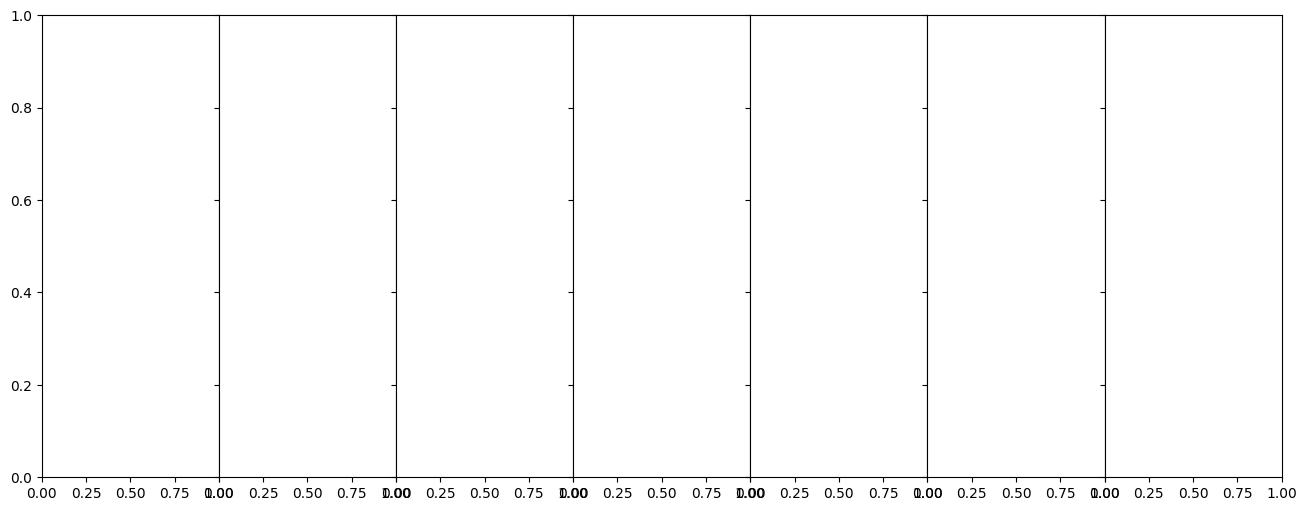

In [21]:
sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]
subject_names = ["Subject 1", "Subject 2", "Subject 3", "average"]

# figure types
fig_types = ["TFL B1+ efficiency [nT/V]", "DREAM B1+ efficiency [nT/V]", "SNR_90"]
    
for data_type, data_stats_type, fig_type in zip(data,data_stats,fig_types):
    
    avg_data = {'CRMBM': 0, 'UCL': 0, 'MNI': 0, 'MGH': 0, 'MPI': 0, 'NTNU': 0, 'MSSM': 0}
   
    fig = plt.figure()
    gs = fig.add_gridspec(1, len(sites), wspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    fig.set_size_inches(16, 6)

    
    j = 0
    i = 0
    
    for k, site in enumerate(sites):    
        while i < (j+3):

            axs[k].plot(data_type[site][subjects[i]])

            avg_data[site] += data_type[site][subjects[i]]
            
            i += 1
        
        j += 3
        
        avg_data[site] = avg_data[site]/3
        
        axs[k].plot(avg_data[site],color="black",linestyle='dashed',linewidth=1)
        axs[k].set_title(sites[k])
        axs[k].grid()
    
    axs[0].legend(subject_names,loc="upper right")

    for ax in axs.flat:
        ax.set(xlabel='Vertebral Levels', ylabel=fig_type, xticks=100*label_positions, xticklabels=vertebral_levels)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')

    if fig_type=="SNR_90":
        ax.set_ylim(0, 1300)
    else:
        ax.set_ylim(0, 85)  
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()


    plt.show()

    


In [22]:
##################################################################################
# genetrate figures for B1+ and SNR CoV along the cord
##################################################################################

IndexError: list index out of range

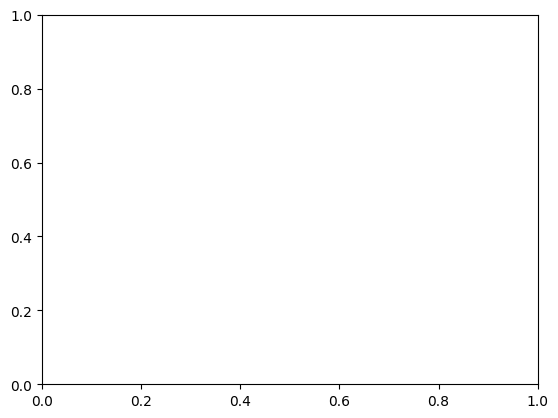

In [23]:
# figure types
fig_types = ["TFL B1+ CoV [nT/V] across C1-T2", "DREAM B1+ CoV [nT/V] across C1-T2", "SNR CoV [arb] across C1-T2"]
subject_names = ["Subject 1", "Subject 2", "Subject 3"]

for data_stats_type, fig_type in zip(data_stats,fig_types):
    
    series = [data_stats_type[i::len(subject_names)] for i in range(len(subject_names))]
    hline_x = np.arange(len(sites))
    hline_width = 0.25

    sub_cov = np.zeros((len(subject_names),len(sites)))

    fig, ax = plt.subplots()


    i = 0 
    for subject_name, subject_series in zip(subject_names, series): 
        
        ax.scatter(sites, [subject_series[k][3]/subject_series[k][2] for k in range(0,len(sites))], label=subject_name)

        for j in range(len(sites)):
            sub_cov[i][j] = subject_series[j][3]/subject_series[j][2]

        i+=1
    
    plt.hlines(np.mean(sub_cov, axis=0),hline_x - hline_width/2, hline_x + hline_width/2, color="black", label="Across subj. mean")
        
    ax.legend()
    ax.set_ylim(0, 0.5)     
    ax.set_title(fig_type)

    plt.grid()


## Load data and generate figures 

In [24]:
###########################################################################################################
# generate figures for B1+, SNR, and 1/g-factor maps obtained at each site (for one representative subject)
###########################################################################################################

In [25]:
# First co-regsiter subjects across sites for better visualisation and flatten the spinal cord (ie, being it into the sagittal midline)

sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]
subject_ids = ["1","2","3"]
site_ref = 'CRMBM'

file_names = ["TFLTB1map", "DREAMTB1avgB1map","acq-coilQaSagLarge_SNR_T0000"]

for subject_id in subject_ids:
    for site in sites:
        print(f"👉 PROCESSING: {site}{subject_id}")
        for file_name in file_names:
            os.chdir(os.path.join(path_data, "sub-"+site+subject_id, "fmap"))
            
            if site == "CRMBM":
                # Flatten the spinal cord in the sagittal plane
                if file_name == "TFLTB1map":
                    !sct_flatten_sagittal -i sub-{site}{subject_id}_{file_name}.nii.gz -s sub-{site}{subject_id}_acq-famp_TB1TFL_seg.nii.gz
                elif file_name == "DREAMTB1avgB1map":
                    !sct_flatten_sagittal -i sub-{site}{subject_id}_{file_name}.nii.gz -s sub-{site}{subject_id}_acq-famp_TB1DREAM_seg.nii.gz
                else:
                    !sct_flatten_sagittal -i sub-{site}{subject_id}_{file_name}.nii.gz -s sub-{site}{subject_id}_{file_name}_seg.nii.gz
            else:
                # Co-register data to reference subject, then flatten the spinal cord in the sagittal plane
                if file_name == "TFLTB1map":
                    !sct_register_multimodal -i sub-{site}{subject_id}_{file_name}.nii.gz -iseg sub-{site}{subject_id}_acq-famp_TB1TFL_seg.nii.gz -d ../../sub-{site_ref}{subject_id}/fmap/sub-{site_ref}{subject_id}_{file_name}.nii.gz -dseg ../../sub-{site_ref}{subject_id}/fmap/sub-{site_ref}{subject_id}_acq-famp_TB1TFL_seg.nii.gz -param step=1,type=seg,algo=centermassrot,metric=MeanSquares
                    !sct_flatten_sagittal -i sub-{site}{subject_id}_{file_name}_reg.nii.gz -s sub-{site}{subject_id}_acq-famp_TB1TFL_seg.nii.gz
                elif file_name == "DREAMTB1avgB1map":
                    !sct_register_multimodal -i sub-{site}{subject_id}_{file_name}.nii.gz -iseg sub-{site}{subject_id}_acq-famp_TB1DREAM_seg.nii.gz -d ../../sub-{site_ref}{subject_id}/fmap/sub-{site_ref}{subject_id}_{file_name}.nii.gz -dseg ../../sub-{site_ref}{subject_id}/fmap/sub-{site_ref}{subject_id}_acq-famp_TB1DREAM_seg.nii.gz -param step=1,type=seg,algo=centermassrot,metric=MeanSquares
                    !sct_flatten_sagittal -i sub-{site}{subject_id}_{file_name}_reg.nii.gz -s sub-{site}{subject_id}_acq-famp_TB1DREAM_seg.nii.gz
                else:
                    !sct_register_multimodal -i sub-{site}{subject_id}_{file_name}.nii.gz -iseg sub-{site}{subject_id}_{file_name}_seg.nii.gz -d ../../sub-{site_ref}{subject_id}/fmap/sub-{site_ref}{subject_id}_{file_name}.nii.gz -dseg ../../sub-{site_ref}{subject_id}/fmap/sub-{site_ref}{subject_id}_{file_name}_seg.nii.gz -param step=1,type=seg,algo=centermassrot,metric=MeanSquares
                    !sct_flatten_sagittal -i sub-{site}{subject_id}_{file_name}_reg.nii.gz -s sub-{site}{subject_id}_{file_name}_seg.nii.gz

            

👉 PROCESSING: CRMBM1


FileNotFoundError: [Errno 2] No such file or directory: '/home/runner/work/coil-qc-code/coil-qc-code/data-human/sub-CRMBM1/fmap'

FileNotFoundError: [Errno 2] No such file or directory: '/home/runner/work/coil-qc-code/coil-qc-code/data-human/sub-CRMBM3/fmap'

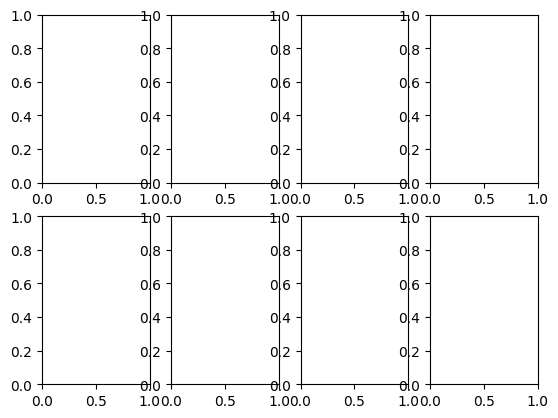

In [26]:
sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]

# map types
map_types = ["TFLTB1map", "DREAMTB1avgB1map", "acq-coilQaSagLarge_SNR_T0000"]

# legend types
legend_types = ["[nT/V]", "[nT/V]", "[arb]", "[arb]", "[arb]"]

# Select individual subject to show
ind_subject = '3'

for map_type, legend_type in zip(map_types,legend_types):
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 4)#, figsize=(10, 8))
    font_size = 12
    axes=axes.flatten() 
        
    for i,site in enumerate(sites):
        # Load data
        os.chdir(os.path.join(path_data, f"sub-{site}{ind_subject}", "fmap"))

        if site=="CRMBM":
            #map=nib.load(f"sub-{site}{ind_subject}_{map_type}_flatten.nii.gz")
            map=nib.load(f"sub-{site}{ind_subject}_{map_type}.nii.gz")
        else:
            #map=nib.load(f"sub-{site}{ind_subject}_{map_type}_reg_flatten.nii.gz")
            map=nib.load(f"sub-{site}{ind_subject}_{map_type}_reg.nii.gz")
        
        if map_type=="TFLTB1map" and ind_subject == '1':
            data=map.get_fdata()[31:82,43:93,round(map.get_fdata().shape[2]/2)]
        elif map_type=="TFLTB1map" and ind_subject == '2':
            data=map.get_fdata()[28:71,37:94,round(map.get_fdata().shape[2]/2)]
        elif map_type=="TFLTB1map" and ind_subject == '3':
            data=map.get_fdata()[28:77,37:98,round(map.get_fdata().shape[2]/2)]
        elif map_type=="DREAMTB1avgB1map" and ind_subject == '1':
            data=map.get_fdata()[29:60,13:66,round(map.get_fdata().shape[2]/2)]
        elif map_type=="DREAMTB1avgB1map" and ind_subject == '2':
            data=map.get_fdata()[20:65,6:56,round(map.get_fdata().shape[2]/2)]
        elif map_type=="DREAMTB1avgB1map" and ind_subject == '3':
            data=map.get_fdata()[25:72,0:60,round(map.get_fdata().shape[2]/2)]
        elif map_type=="acq-coilQaSagLarge_SNR_T0000" and ind_subject == '1':
            data=map.get_fdata()[224:302,213:292,round(map.get_fdata().shape[2]/2)]
        elif map_type=="acq-coilQaSagLarge_SNR_T0000" and ind_subject == '2':
            data=map.get_fdata()[224:302,197:289,round(map.get_fdata().shape[2]/2)]
        elif map_type=="acq-coilQaSagLarge_SNR_T0000" and ind_subject == '3':
            data=map.get_fdata()[224:302,195:299,round(map.get_fdata().shape[2]/2)]
    
        axes[-1].axis('off') 
        # Defining dynamic range
        axes[-1].axis('off')            
        dynmin = 0 
        if map_type=="acq-coilQaSagLarge_SNR_T0000":
            dynmax = 230
        else:
            dynmax = 60    
            
        splot=axes[i]
        im = splot.imshow((data.T), cmap='viridis', origin='lower',vmin=dynmin,vmax=dynmax)
        
        splot.set_title(site, size=font_size)
        splot.axis('off')

    # If map_type is B1+ or SNR, and in-vivo subject, then the last subplot will be an anatomical scan with the dialted SC segmentation overlaid onto it
    #if (map_type == "TFLTB1map" or map_type == "DREAMTB1avgB1map" or map_type == "acq-coilQaSagLarge_SNR_T0000") and ind_subject != '4':

        #os.chdir(os.path.join(path_data, f"sub-{sites[0]}{ind_subject}", "fmap"))
        # Load data
        #map=nib.load(f"sub-{sites[0]}{ind_subject}_acq-anat_TB1TFL.nii.gz")
        #data=map.get_fdata()[:,:,round(map.get_fdata().shape[2]/2)]
        #splot=axes[-1]
        #splot.imshow((data.T), cmap='gray', origin='lower',vmin=0,vmax=2000)
        #splot.axis('off')
    
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.1, hspace=0.1, right=0.9)

    # Colorbar
    # Assume that the colorbar should start at the bottom of the lower row of subplots and
    # extend to the top of the upper row of subplots
    cbar_bottom = 0.25  # This might need adjustment
    cbar_height = 0.5  # This represents the total height of both rows of subplots
    cbar_dist = 1.01
    cbar_ax = fig.add_axes([cbar_dist, cbar_bottom, 0.03, cbar_height])
    cbar = plt.colorbar(im, cax=cbar_ax)

    cbar_ax.set_title(legend_type, size=12)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/runner/work/coil-qc-code/coil-qc-code/data-human/sub-CRMBM2/fmap'

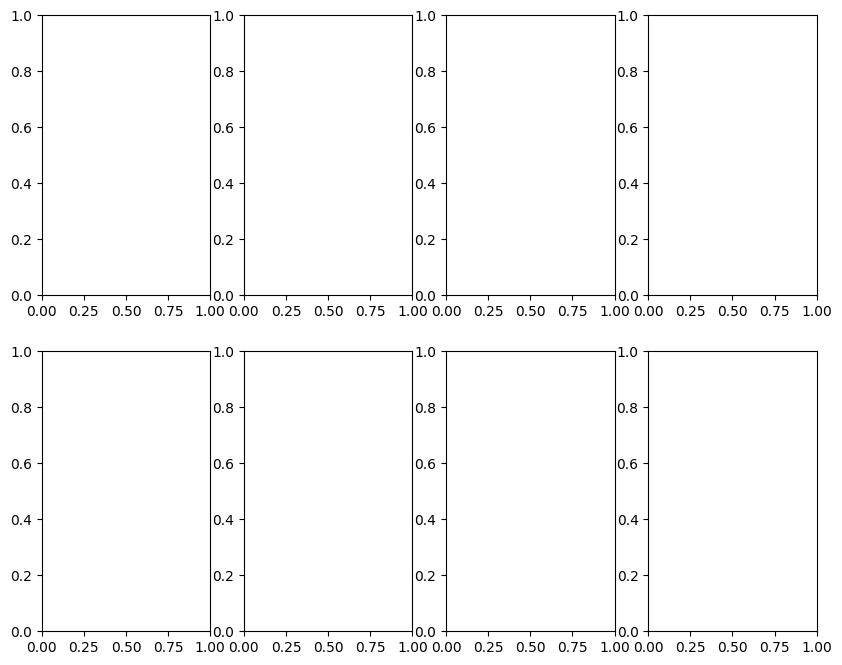

In [27]:
sites = ["CRMBM", "MNI", "MPI", "MSSM", "UCL", "MGH", "NTNU"]

# map types
map_types = ["acq-coilQaSagSmall_GFactor", "T2starw"]

# legend types
legend_types = ["1/g", "[arb]"]

# Select individual subject to show
ind_subject = '2'

mean_gfac = {}
max_gfac = {}

for map_type, legend_type in zip(map_types,legend_types):
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 8))
    font_size = 12
    axes=axes.flatten() 
        
    for i,site in enumerate(sites):
        # Load data
        if map_type=="T2starw":
            os.chdir(os.path.join(path_data, f"sub-{site}{ind_subject}", "anat"))
            map=nib.load(f"sub-{site}{ind_subject}_{map_type}.nii.gz")
            data=map.get_fdata()[:,:,round(map.get_fdata().shape[2]/2)]
        else:         
            os.chdir(os.path.join(path_data, f"sub-{site}{ind_subject}", "fmap"))
            map=nib.load(f"sub-{site}{ind_subject}_{map_type}.nii.gz")
            # The 4th dimension inlcudes 12 acceleration maps: 
            #['R 2','R 3', 'R 4', 'R 6', 'R 8', 'R 2 x 2', 'R 2 x 3', 'R 3 x 2', 'R 3 x 3', 'R 3 x 4', 'R 4 x 3', 'R 4 x 4']
            # show the R = 2 x 2 map
            data=(map.get_fdata()[64:191,64:191,round(map.get_fdata().shape[2]/2),5])/1000
            gfac_data=(map.get_fdata()[round(map.get_fdata().shape[0]/2)-10:round(map.get_fdata().shape[0]/2)+10,round(map.get_fdata().shape[1]/2)-10:round(map.get_fdata().shape[1]/2)+10,round(map.get_fdata().shape[2]/2),5])
            mean_gfac[site]=np.nanmean(gfac_data)/1000
            max_gfac[site]=np.max(gfac_data)/1000
    
        # Plot  
        splot=axes[i]
        dynmin = 0 
        if map_type=="acq-coilQaSagSmall_GFactor":
            dynmax = 1
            axes[-1].axis('off')
            splot.text(0, 3, r'mean 1/g='+str(round(mean_gfac[site],4)), size=10)
            #splot.text(0, 12, r'max gfac='+str(round(max_gfac[site],3)), size=10)
            
            x = [data.shape[0]/2-10, data.shape[1]/2-10] 
            y = [data.shape[0]/2-10, data.shape[1]/2+10] 
            splot.plot(x, y, color="black", linewidth=2) 
            
            x = [data.shape[0]/2-10, data.shape[1]/2+10] 
            y = [data.shape[0]/2+10, data.shape[1]/2+10] 
            splot.plot(x, y, color="black", linewidth=2) 

            x = [data.shape[0]/2+10, data.shape[1]/2+10] 
            y = [data.shape[0]/2+10, data.shape[1]/2-10] 
            splot.plot(x, y, color="black", linewidth=2)

            x = [data.shape[0]/2+10, data.shape[1]/2-10] 
            y = [data.shape[0]/2-10, data.shape[1]/2-10] 
            splot.plot(x, y, color="black", linewidth=2) 
        else:
            dynmax = 3000
            axes[-1].axis('off') 
            
        im = splot.imshow((data.T), cmap='viridis', origin='lower',vmin=dynmin,vmax=dynmax)  
        splot.set_title(site, size=font_size)
        splot.axis('off')
    
    plt.tight_layout()

    # Colorbar
    # Assume that the colorbar should start at the bottom of the lower row of subplots and
    # extend to the top of the upper row of subplots
    cbar_bottom = 0.25  # This might need adjustment
    cbar_height = 0.5  # This represents the total height of both rows of subplots
    cbar_dist = 1.01
    cbar_ax = fig.add_axes([cbar_dist, cbar_bottom, 0.03, cbar_height])
    cbar = plt.colorbar(im, cax=cbar_ax)

    cbar_ax.set_title(legend_type, size=12)
    plt.show()


In [28]:
###########################################################################################################
# generate tiled figure with individual channel GRE maps for a single subject at one site 
###########################################################################################################

In [29]:
sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]

# Select subject to show
subject = '1'

        
for i,site in enumerate(sites):

    gre_files=sorted(glob.glob(os.path.join(path_data, f"sub-{site}{subject}", "anat", '*uncombined*.nii.gz')))
        
    #Tiled figure in a five-row layout
    rows=int(np.ceil(len(gre_files)/4))
    cols=int(np.ceil(len(gre_files)/rows))

    fig=plt.figure(figsize=(15, 20))
    
    ax = fig.subplots(rows,cols,squeeze=True)
    
    for row in range(rows):
        for col in range(cols):

            i = row*cols+col

            if i < len(gre_files):
            
                #read in files
                data_to_plot=(nib.load(gre_files[i])).get_fdata() #load in nifti object, get only image data
                data_to_plot=np.rot90(data_to_plot[:,:,int(np.floor(data_to_plot.shape[2]/2))]) #central slice
           
                ax[row,col].imshow(data_to_plot,cmap=plt.cm.gray,clim=[0, 300])
                ax[row,col].text(0.5, 0.05, 'Rx channel : ' + str(i+1),horizontalalignment='center', transform=ax[row,col].transAxes,color='white',fontsize=17)
                ax[row,col].axis('off')

    plt.axis('off')
    plt.subplots_adjust(hspace=0,wspace=0)
    fig.suptitle(site, fontsize=20, y=0.9)


ZeroDivisionError: division by zero

## Finished

In [30]:
# Indicate duration of data processing

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

# Convert seconds to a timedelta object
total_time_delta = timedelta(seconds=total_time)

# Format the timedelta object to a string
formatted_time = str(total_time_delta)

# Pad the string representation if less than an hour
formatted_time = formatted_time.rjust(8, '0')

print(f"Total Runtime [hour:min:sec]: {formatted_time}")

Total Runtime [hour:min:sec]: 0:00:03.375462
